In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Conv2D, AveragePooling2D, Input, MaxPooling2D, UpSampling2D
import tensorflow as tf
# отключим GPU (нужно для платформы Apple M1)
tf.config.set_visible_devices([], 'GPU')

In [2]:
def generate_line_images(num_images):
    """Функция для генерации случайных изображений вертикальных и горизонтальных линий и меток к ним
    Args:
        num_images (int): Количество изображений
    Returns:
        tuple[ndarray, ndarray]: Кортеж с изображениями и метками.
    """
    images = np.zeros((num_images, 20, 20), dtype=np.uint8)
    labels = np.zeros((num_images,), dtype=np.uint8)

    for i in range(num_images):
        line_type = np.random.randint(0, 2)  # 0 for vertical, 1 for horizontal
        labels[i] = line_type

        if line_type == 1:  # horizontal line
            row = np.random.randint(0, 17)
            col = np.random.randint(0, 20)
            images[i, row:row+4, col] = 1
        else:  # vertical line
            row = np.random.randint(0, 20)
            col = np.random.randint(0, 17)
            images[i, row, col:col+4] = 1

    return images, labels

In [287]:
# Сгенерируем изображения
num_images = int(1e3)
images, labels = generate_line_images(num_images)

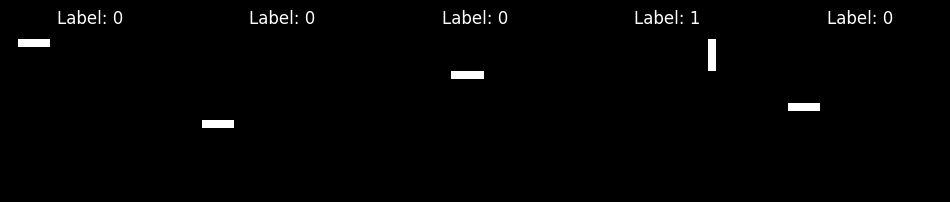

In [288]:
# Посмотрим на картинки на первые 5
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.show()

In [289]:
# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [303]:
# Создание простую полносвязную сеть с 10ю нейронами
model = Sequential([
    Flatten(input_shape=(20, 20)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Оценка модели на тестовой выборке
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/20
18/18 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5107 - val_loss: 0.6895 - val_accuracy: 0.5357
Epoch 2/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5393 - val_loss: 0.6814 - val_accuracy: 0.6214
Epoch 3/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6661 - accuracy: 0.6393 - val_loss: 0.6729 - val_accuracy: 0.6429
Epoch 4/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.6518 - val_loss: 0.6616 - val_accuracy: 0.6571
Epoch 5/20
18/18 [==============================] - 0s 2ms/step - loss: 0.6324 - accuracy: 0.6929 - val_loss: 0.6461 - val_accuracy: 0.6571
Epoch 6/20
18/18 [==============================] - 0s 2ms/step - loss: 0.5937 - accuracy: 0.7661 - val_loss: 0.6255 - val_accuracy: 0.6571
Epoch 7/20
18/18 [==============================] - 0s 2ms/step - loss: 0.5645 - accuracy: 0.7679 - val_loss: 0.6026 - val_accuracy: 0.6929
Epoch 8/20
18/18 [==

In [304]:
# посмотрим на структуру модели
pd.DataFrame(model.layers)

,0
0,<keras.layers.reshaping.flatten.Flatten object...
1,<keras.layers.core.dense.Dense object at 0x2c5...
2,<keras.layers.regularization.dropout.Dropout o...
3,<keras.layers.core.dense.Dense object at 0x2a4...
4,<keras.layers.regularization.dropout.Dropout o...
5,<keras.layers.core.dense.Dense object at 0x2c3...


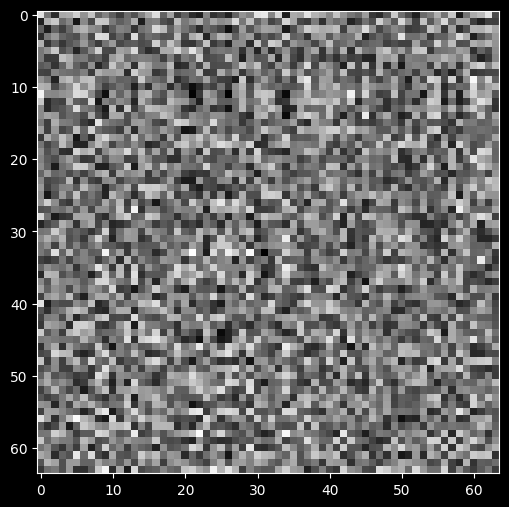

In [306]:
# так выклядят веса второго нейронного слоя. Выглядит, как шум.
# При таком маленьком датасете в 1000 изображений, из которых 200 отобраны на валидацию полносвязная сеть не может
# полноценно работать. На большом датасете 100к изображений сеть скорее всего запоминает все возможные варианты.
plt.figure(figsize=(6, 6))
plt.imshow(model.layers[3].get_weights()[0].transpose(), cmap='gray')

# Попробуем сверточную архитектуру

In [307]:
# Создадим модель, используя популярную архитектуру LeNet-5
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(20, 20, 1), padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train[:, :, :, None], y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Оценка модели на тестовой выборке
test_loss, test_acc = model.evaluate(X_test[:, :, :, None], y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/20
18/18 [==============================] - 0s 8ms/step - loss: 0.6896 - accuracy: 0.5911 - val_loss: 0.6879 - val_accuracy: 0.5857
Epoch 2/20
18/18 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5768 - val_loss: 0.6679 - val_accuracy: 0.6214
Epoch 3/20
18/18 [==============================] - 0s 5ms/step - loss: 0.6282 - accuracy: 0.6964 - val_loss: 0.6015 - val_accuracy: 0.6714
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.5242 - accuracy: 0.8018 - val_loss: 0.4525 - val_accuracy: 0.9571
Epoch 5/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3699 - accuracy: 0.9643 - val_loss: 0.2873 - val_accuracy: 0.9857
Epoch 6/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2365 - accuracy: 0.9946 - val_loss: 0.1540 - val_accuracy: 1.0000
Epoch 7/20
18/18 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9929 - val_loss: 0.0494 - val_accuracy: 1.0000
Epoch 8/20
18/18 [==

In [308]:
# посмотрим на структуру модели
pd.DataFrame(model.layers)

,0
0,<keras.layers.convolutional.conv2d.Conv2D obje...
1,<keras.layers.pooling.average_pooling2d.Averag...
2,<keras.layers.regularization.dropout.Dropout o...
3,<keras.layers.convolutional.conv2d.Conv2D obje...
4,<keras.layers.pooling.average_pooling2d.Averag...
5,<keras.layers.regularization.dropout.Dropout o...
6,<keras.layers.reshaping.flatten.Flatten object...
7,<keras.layers.core.dense.Dense object at 0x288...
8,<keras.layers.regularization.dropout.Dropout o...
9,<keras.layers.core.dense.Dense object at 0x288...


In [309]:
# Выберем экстрактор признаков и получим выход 5-го слоя, после MaxPooling
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[4].output)
features = feature_extractor.predict(X_test[:, :, :, None])

10/10 [==============================] - 0s 1ms/step


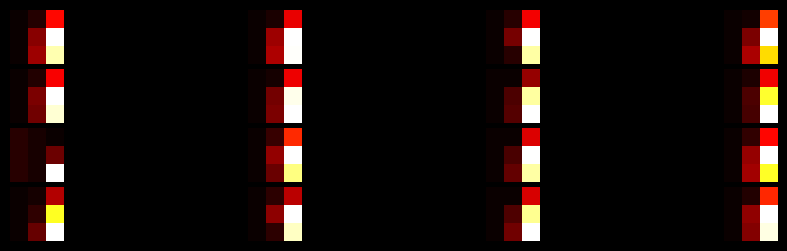

In [316]:
# Визуализируем фильтры для изображения с индексом 0
n_filters = features.shape[-1]
n_columns = 4
n_rows = n_filters // n_columns + int(n_filters % n_columns > 0)

fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 3))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(n_filters):
    row = i // n_columns
    col = i % n_columns
    axes[row, col].imshow(features[0, :, :, i], cmap='hot')
    axes[row, col].axis('off')

plt.show()

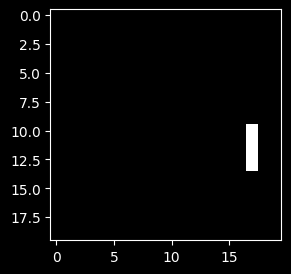

In [317]:
# Посмотрим на само изображение
plt.figure(figsize=(3, 3))
plt.imshow(X_test[0], cmap='gray')

# Сверточная архитектура хорошо выделяет ключевые признаки даже на маленьком датасете.

## Попробуем построить автоэнкодер для восстановления исходного изображения из скрытого представления

In [375]:
def build_autoencoder(input_shape=(20, 20, 1)):
    # Encoder
    encoder_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(encoder_input, decoded)

    return autoencoder

In [376]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
6/6 [==============================] - 1s 54ms/step - loss: 0.6502 - val_loss: 0.5085
Epoch 2/50
6/6 [==============================] - 0s 36ms/step - loss: 0.3493 - val_loss: 0.1634
Epoch 3/50
6/6 [==============================] - 0s 35ms/step - loss: 0.1568 - val_loss: 0.1485
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.1483 - val_loss: 0.1505
Epoch 5/50
6/6 [==============================] - 0s 35ms/step - loss: 0.1512 - val_loss: 0.1527
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 0.1525 - val_loss: 0.1531
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 0.1528 - val_loss: 0.1530
Epoch 8/50
6/6 [==============================] - 0s 42ms/step - loss: 0.1526 - val_loss: 0.1527
Epoch 9/50
6/6 [==============================] - 0s 41ms/step - loss: 0.1521 - val_loss: 0.1519
Epoch 10/50
6/6 [==============================] - 0s 38ms/step - loss: 0.1511 - val_loss: 0.1504
Epoch 11/50
6/6 [============

In [377]:
# Восстановление изображений
decoded_imgs = autoencoder.predict(X_test)

10/10 [==============================] - 0s 7ms/step


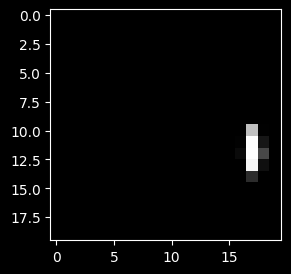

In [380]:
plt.figure(figsize=(3, 3))
plt.imshow(decoded_imgs[0], cmap='gray')
plt.show()